# Notebook 1 : Selection Function and Survey Footprint

This notebook is intended to show an example of how to use the  observational selection function for Milky Way satellites derived in DELVE Milky Way Census I paper. The Census contains data from 3 different census DES, DELVE and PS1 all of which have different selection functions.

# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import yaml
from os.path import join,exists
import healpy as hp

import astropy.units as u
import astropy.coordinates as coords


In [2]:
config = yaml.safe_load(open('data/read_config.yaml'))

BITS = config['maskbits']
BADBITS = (BITS['EBV'] | BITS['ASSOC'] | BITS['STAR'] | BITS['FOOT'] | BITS['DENSITY'] )

def get_filepath(survey,filetype):
    """Get the filepath for a specific survey and filetype.
    
    Parameters
    ----------
    survey   : survey of interest ['des','ps1']
    filetype : type of data file
    
    Returns
    -------
    filepath : path to file
    """
    filepath = join(config['datadir'],config[survey][filetype])
    return filepath

def detect_prob(ra, dec,distance, abs_mag,  r_physical, brightness_flag = False): 
    
    
    delve_pdet = delve_ssf.predict(distance=distance,abs_mag=abs_mag,r_physical=r_physical,ra=ra,dec=dec)
    des_pdet = des_ssf.predict(distance=distance,abs_mag=abs_mag,r_physical=r_physical,ra=ra,dec=dec)
    ps1_pdet = ps1_ssf.predict(distance=distance,abs_mag=abs_mag,r_physical=r_physical,ra=ra,dec=dec)
    
    result = delve_pdet + des_pdet + ps1_pdet
    
    if brightness_flag:
        bright = mv < -12.5
        result[bright] = 1.0

    return result


class SurveySelectionFunction(object):
    """Survey selection function including spatial information."""

    def __init__(self, survey):
        """Initialize survey selection function."""
        self.survey = survey
        print("Loading model...")
        self.model = xgb.XGBClassifier()
        self.model.load_model(get_filepath(self.survey,'model'))
        print("Loading mask...") # This can take a while...
        self.mask = hp.read_map(get_filepath(self.survey,'mask'),dtype=int)
        print("Loading stellar density map...")
        self.density = hp.read_map(get_filepath(self.survey,'density'))

    @staticmethod
    def get_hpxmap_value(hpxmap,lon,lat):
        """Get the value of a healpix map at a given location.
        
        Parameters
        ----------
        hpxmap : HEALPix map (must be in same frame as `lon` and `lat`)
        lon : longitude [deg]
        lat : latitude [deg]
        
        Returns
        -------
        value : healpix map value
        """
        nside = hp.get_nside(hpxmap)
        pix   = hp.ang2pix(nside,lon,lat,lonlat=True)
        return hpxmap[pix]
        
    def get_stellar_density(self, ra, dec):
        """Calculate the stellar density at the location of each satellite.

        Parameters
        ----------
        ra : right ascension [deg]
        dec: declination [deg]
        
        Returns
        -------
        stellar_density : stellar density [stars/arcmin^2]
        """
        return self.get_hpxmap_value(self.density,ra,dec)

    def get_mask_value(self, ra, dec):
        """Calculate the mask value at the location of each satellite.

        Parameters
        ----------
        ra : right ascension [deg]
        dec: declination [deg]
        
        Returns
        -------
        value : mask value
        """
        return self.get_hpxmap_value(self.mask,ra,dec)
    
    def predict(self, distance, abs_mag, r_physical, ra, dec):
        """Predict the satellite detection probability for a survey.
        
        Parameters
        ----------
        distance   : Heliocentric distance [kpc]
        abs_mag    : Absolute V-band magnitude
        r_physical : Physical azimuthally averaged half-light radius [kpc]
        ra         : Right ascension [deg]
        dec        : Declination [deg]

        Returns
        -------
        pdet : detection probability
        """
        # Calculate the stellar density at the location of each satellite.
        stellar_density = self.get_stellar_density(ra,dec)
        
        # Evaluate the model for each satellite
        x_eval = np.vstack([np.log10(distance), abs_mag, np.log10(r_physical), stellar_density]).T
        pred = self.model.predict_proba(x_eval)[:,1]

        #Calculate the mask value at the location of each satellite.
        mask_value = self.get_mask_value(ra,dec)
        # Set pdet to zero for satellites in masked area
        bad = (mask_value & BADBITS) != 0
        pred[bad] = 0
        
        return pred



In [3]:
delve_ssf = SurveySelectionFunction('delvedr3')
des_ssf = SurveySelectionFunction('desy6')
ps1_ssf = SurveySelectionFunction('ps1d')

Loading model...
Loading mask...
Loading stellar density map...
Loading model...
Loading mask...
Loading stellar density map...
Loading model...
Loading mask...


/Users/chinyi/anaconda3/envs/astropy310/lib/python3.10/site-packages/xgboost/sklearn.py:1037: UserWarning: [21:47:22] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_7eg2b3w9sf/croot/xgboost-split_1749630922962/work/src/learner.cc:1069: Loading model from XGBoost < 1.0.0, consider saving it again for improved compatibility
  self.get_booster().load_model(fname)


Loading stellar density map...


# Example 1: Galaxy Detection Probability at Fixed Stellar Density

Here we present a minimal example of loading and evaluating the classifiers. In this example, you need to supply the galaxy properties (distance, absolute magnitude, and size), the stellar density of the Milky Way background stars, and the survey of interest.

In [4]:
delve_model = xgb.XGBClassifier()
filename = get_filepath('delvedr3','model') #choose between delvedr3, desy6 and ps1d
print("Loading model from %s..."%filename)
delve_model.load_model(filename)

Loading model from data/classifier_stellar_delvedr3_v0.model...


In [5]:
distance        = 100.0 # Heliocentric distance [kpc]
abs_mag         = -4.0  # Absolute V-band magnitude
r_physical      = 0.1   # Physical azimuthally averaged half-light radius [kpc]
stellar_density = 1.0   # Stellar density (r < 22) [stars/arcmin^2]

x_eval = np.vstack([np.log10(distance), abs_mag, np.log10(r_physical), stellar_density]).T
ps1_pdet = delve_model.predict_proba(x_eval)[:,1]
print("DELVE detection probability:",ps1_pdet)

DELVE detection probability: [0.75517106]


# Example 2: Plotting the Survey Footprint Mask

However, our census is more complex than what is shown in Example 1. A first complication arises from the fact that different surveys have distinct footprints, and additional geometric masks result in zero coverage in certain regions. Here we show how the DELVE footprint and the Geometric mask

In [6]:
delve_map = hp.read_map('data/delve_census_official_map_v0.fits.gz')

In [7]:
npix=  hp.nside2npix(4096)  

# DES coverage
desy6 = np.ones(npix)*hp.UNSEEN
desy6[(delve_map==1)| (delve_map==5)] = 1

# DELVE coverage
delve = np.ones(npix)*hp.UNSEEN
delve[(delve_map==2)| (delve_map==6)] = 1

# PS1 coverage
ps1 = np.ones(npix)*hp.UNSEEN
ps1[(delve_map==3)| (delve_map==7)] = 1

# Geometric mask
geo_mask = np.ones(npix)*hp.UNSEEN
geo_mask[(delve_map>=8)& (delve_map<128)] = 1


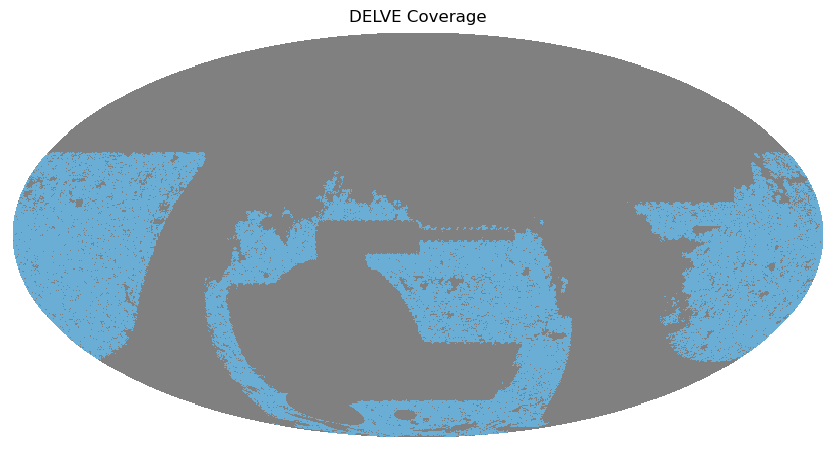

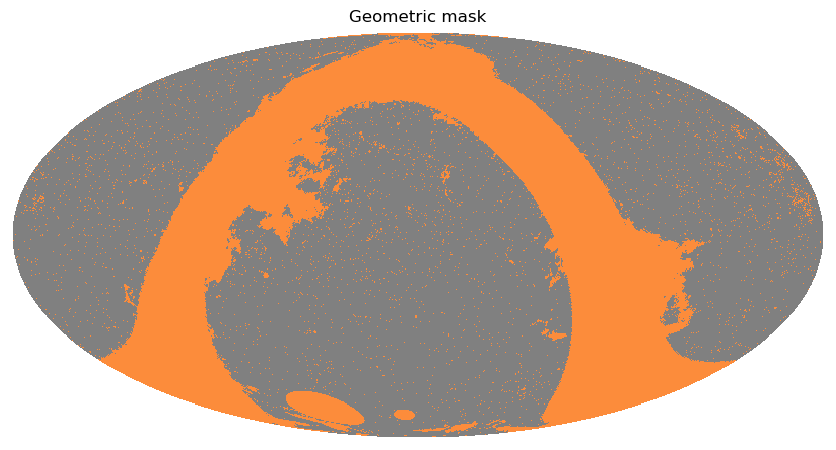

In [8]:
hp.mollview(delve, title='DELVE Coverage' , cmap='Blues', cbar=False)
hp.mollview(geo_mask, title='Geometric mask', cmap='Oranges', cbar=False)


# Example 3: Census Detection probability given RA and DEC

To account for the spatial dependence of our census, we provide a lightweight class that encapsulates this information. Given the RA, Dec, and galaxy properties, it can estimate the detection probability of a hypothetical galaxy, taking into account the survey coverage, and the underlying stellar density.

In [9]:
distance        = 100.0 # Heliocentric distance [kpc]
abs_mag         = -4.0  # Absolute V-band magnitude
r_physical      = 0.02  # Physical azimuthally averaged half-light radius [kpc]
ra              = 20    #(deg from 0 to -360)
dec             = 40    #(deg from -90 to -90)


detect_prob(ra, dec,distance, abs_mag,  r_physical)

array([0.46077013], dtype=float32)

# Example 4: Detection probability over the whole sky

To tie everything together, we evaluate our selection function across the entire sky for a hypothetical galaxy with fixed properties. As expected, galaxies are not detectable near the Galactic plane. We also find that the detection probability is higher in the southern hemisphere, where DES and DELVE provide coverage, than in the northern hemisphere, which is covered by PS1.

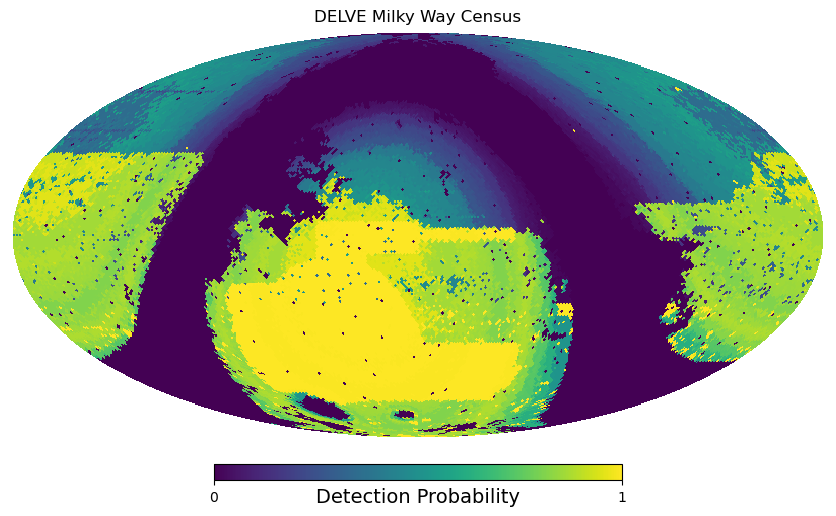

In [10]:
# HEALPix parameters
nside = 64
npix = hp.nside2npix(nside)


distance        = 0.1*np.ones(npix)       # Heliocentric distance [kpc]
abs_mag         = -2.2*np.ones(npix)      # Absolute V-band magnitude
r_physical      = 0.01*np.ones(npix)      # Physical azimuthally averaged half-light radius [kpc]

# Get theta, phi for each HEALPix pixel (radians)
ra, dec = hp.pix2ang(nside, np.arange(npix), lonlat=True)

# Evaluate function at each pixel
values = detect_prob(ra, dec,distance, abs_mag ,  r_physical )

# Plot using healpy mollview
hp.mollview(values, title="DELVE Milky Way Census", unit="Detection Probability", cmap="viridis", min=0, max=1)

plt.show()